## Methods Comparison for Assessing Population Structure
Alexander Eyre (2022)
____


Hayward, J., Castelhano, M., Oliveira, K. et al. Complex disease and phenotype mapping in the domestic dog. Nat Commun 7, 10460 (2016). https://doi.org/10.1038/ncomms10460

____
Principal Component Analysis (PCA):  Linear Analysis that uses eigenanalysis to produce vectors called principal components, where each component captures the axis of maximum variance in the data while being orthogonal to the previous components.

Multidimensional Scaling (MDS):  First, the pairwise distances between each pair of samples in the original space are calculated. Next, a projection to the low-dimensional space is learned by minimizing the differences between the pairwise distances in the lowdimensional space and the calculated distances in the original space. MDS has largely been superseded by other distance-based methods.

t-distributed Stochastic Neighbor Embedding (t-SNE):  This technique aims to reconstruct the graph in a lower-dimensional space, while maintaining the topological structure from the original high-dimensional space.

Uniform Manifold Approximation and Projection (UMAP):  This technique aims to reconstruct the graph in a lower-dimensional space, while maintaining the topological structure from the original high-dimensional space.

Autoencoders (AE):  Neural network that is commonly used for learning a set of features from data in an unsupervised fashion. The encoder network 'fencoder' compresses the highdimensional input x into a lower-dimensional space, while the
decoder network 'fdecoder' outputs an approximation x^ of the original input using only the low-dimensional embedding provided by the encoder. Since the embedding space acts as a bottleneck, it must efficiently represent as much of the relevant information as possible from the original signal. For this reason, AEs have often been used as a means of extracting informative and discriminative features for downstream tasks, where the embedding representation can be re-used for another purpose.

Variational Autoencoders (VAE):   Latent variable model that defines a generative model over data.  Are trained using stochastic sampling.  VAEs and their many variants are useful models because the posterior density of the model approximates the tractable prior. This means that sampling new data from the complex, multi-modal data distribution is as simple as sampling from the known prior. It also means that, unlike with the AE, the density of the posterior is approximately continuous in the latent space and so it is often possible to smoothly interpolate between points in this space.

Motivation and Methods Descriptions:  Ubbens J, Feldmann MJ, Stavness I, Sharpe AG. Quantitative evaluation of nonlinear methods for population structure visualization and inference. G3 (Bethesda). 2022 Aug 25;12(9):jkac191. doi: 10.1093/g3journal/jkac191. PMID: 35900169; PMCID: PMC9434256.

____
### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import pytorch_lightning as pl
plt.style.use('seaborn-darkgrid')

# Data Preparation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from itertools import compress

# Analyses
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from umap import UMAP
from torch.utils.data import TensorDataset, DataLoader

# Written Python Scripts
from ae_model import autoencoder
from vae_model import VAE

____
### Define Functions

In [2]:
def imputer(dataset):
    imp = IterativeImputer(max_iter = 500, random_state = 101)
    imp.fit(dataset)
    curr_data = imp.transform(dataset)
    return pd.DataFrame(curr_data, columns = dataset.columns)

____
### Data Import
The genotype data to be used in this project should be in the PLINK .raw format.  This can be generated using PLINK's --recodeA command.

In [3]:
# Import Datasets
all_data             = pd.read_csv("Hayward_pruned.raw", 
                                   delimiter = " ",
                                   low_memory = False)
dog_info             = pd.read_csv("breeds.txt",
                                   delimiter = "\t",
                                   header = None)

In [4]:
# Reduce Datasets
header_data          = all_data.iloc[:,:6]
geno_data            = all_data.iloc[:,6:]

In [5]:
# Choose Top Dog Breeds
count                = np.ceil(0.01 * len(dog_info))

breed_list           = list(dog_info.iloc[:,1].value_counts().index)
top_breeds           = list(compress(breed_list, list(dog_info.iloc[:,1].value_counts() >= count)))

In [6]:
# Find Top Dog Breed Indices
# This creates a list of dog IDs that will be present in the final dataset
idx                  = 0
dog_breed_list       = list(dog_info.iloc[:,1])
dog_idx_list         = []

while idx < len(list(dog_info.iloc[:,1])):
    if dog_breed_list[idx] in top_breeds:
        dog_idx_list.append(list(dog_info.iloc[:,0])[idx])
    idx = idx + 1

# This creates a list of Booleans the length of the genotype dataset 
idx                  = 0
geno_idx_list        = []

while idx < len(list(header_data['IID'])):
    if list(header_data['IID'])[idx] in dog_idx_list:
        geno_idx_list.append(True)
    else:
        geno_idx_list.append(False)
    idx = idx + 1        

In [7]:
# Build reduced datasets
geno_data            = geno_data[geno_idx_list]
geno_data            = geno_data.set_axis(list(np.arange(0,len(geno_data))), axis = 0)
header_data          = header_data[geno_idx_list]

In [8]:
# Build colorization
breed_info           = []

for entry in header_data['IID']:
    breed_info.append(list(dog_info.iloc[:,1][dog_info.iloc[:,0] == entry])[0])

____
### Data Preparation

In [9]:
# Impute missing genotypes
# Takes slightly less than 2 hours
idx                 = 0 
chunk_size          = 100
test                = False

while idx < len(geno_data.columns):
    geno_data.iloc[:,idx:idx+chunk_size] = imputer(geno_data.iloc[:,idx:idx+chunk_size]).round(decimals = 0)
    
    if test == True:
        idx = len(geno_data.columns) + 1
    elif idx + chunk_size >= len(geno_data.columns):
        test = True
        idx = len(geno_data.columns) - 1
    else:
        idx = idx + chunk_size        

In [10]:
geno_data

,BICF2P1383091_A,TIGRP2P259_rs8993730_G,BICF2G630707932_A,BICF2G630707957_A,BICF2G630707977_A,BICF2G630708028_G,BICF2G630708039_A,BICF2G630708125_A,BICF2S23217029_A,BICF2P562192_C,...,BICF2S23718171_A,BICF2G630539179_A,BICF2G630539075_A,TIGRP2P135925_rs8805269_A,BICF2G630539057_G,BICF2G630539022_A,chrX_6580942_A,chrX_6588633_G,BICF2G630538994_A,chrX_6608199_G
0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


____
### Analyses
Select genotype dataset

Select colorization scheme

In [11]:
# Select Dataset
curr_data            = geno_data

# Select Colorization Scheme
curr_color           = breed_info

____
#### Principal Component Analysis (PCA)

In [12]:
# Run PCA
pca            = PCA(n_components = 100,
                     random_state = 101)
curr_pca       = pca.fit_transform(curr_data)

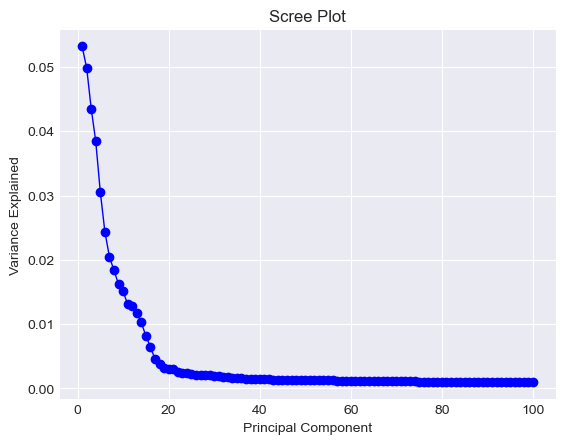

In [13]:
# Scree Plot
PC_values      = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [14]:
# Setup the top two components for the PCA
i   = 0
PC1 = []
PC2 = []
while i < len(curr_pca):
    PC1.append(curr_pca[i][0])
    PC2.append(curr_pca[i][1])
    i = i + 1

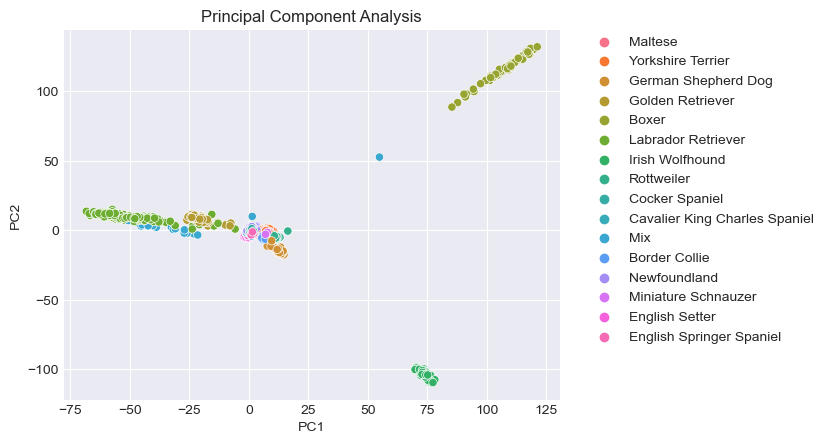

In [33]:
# Plot the top two components against eachother
sns.scatterplot(x = PC1, 
                y = PC2, 
                hue = curr_color)
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Multidimensional Scaling (MDS)

In [16]:
# Run MDS
mds            = MDS(n_components = 2,
                     max_iter = 300,
                     eps = 1e-3,
                     random_state = 101)
curr_mds       = mds.fit_transform(curr_data)

In [17]:
# Setup X and Y values for plot
i              = 0
mds_X          = []
mds_Y          = []
while i < len(curr_mds):
    mds_X.append(curr_mds[i][0])
    mds_Y.append(curr_mds[i][1])
    i = i + 1

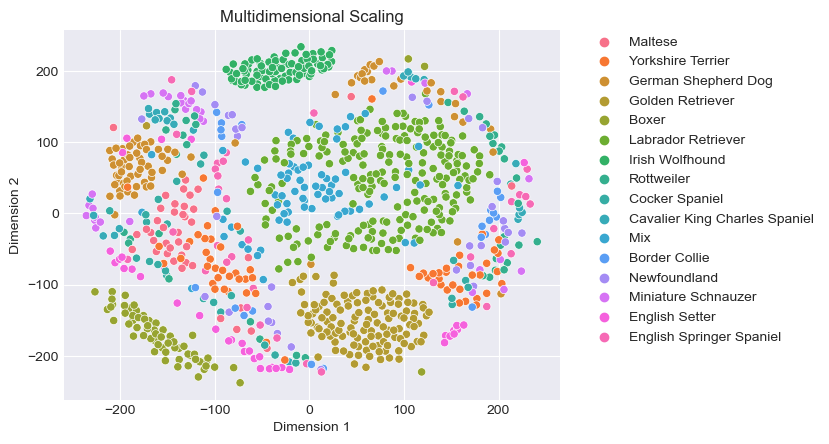

In [35]:
# Plot MDS
sns.scatterplot(x = mds_X, 
                y = mds_Y, 
                hue = curr_color)
plt.title("Multidimensional Scaling")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [19]:
tsne           = TSNE(n_components = 2,
                      perplexity = 30,
                      early_exaggeration = 12,
                      learning_rate = 200,
                      n_iter = 1000,
                      n_iter_without_progress = 300,
                      min_grad_norm = 1e-7,
                      metric = 'euclidean',
                      init = 'random',
                      random_state = 101)
curr_tsne      = tsne.fit_transform(curr_data)

In [20]:
# Setup X and Y values for plot
i              = 0
tsne_X         = []
tsne_Y         = []
while i < len(curr_tsne):
    tsne_X.append(curr_tsne[i][0])
    tsne_Y.append(curr_tsne[i][1])
    i = i + 1

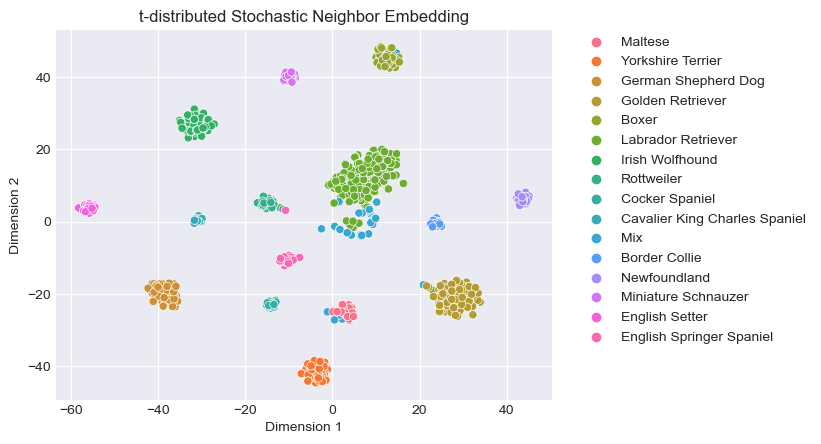

In [37]:
# Plot tSNE
sns.scatterplot(x = tsne_X, 
                y = tsne_Y, 
                hue = curr_color)
plt.title("t-distributed Stochastic Neighbor Embedding")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Uniform Manifold Approximation and Projection (UMAP)

In [22]:
umap           = UMAP(n_components = 2,
                      init = 'random',
                      random_state = 101)
curr_umap      = umap.fit_transform(curr_data)

In [23]:
# Setup X and Y values for plot
i              = 0
umap_X         = []
umap_Y         = []
while i < len(curr_umap):
    umap_X.append(curr_umap[i][0])
    umap_Y.append(curr_umap[i][1])
    i = i + 1

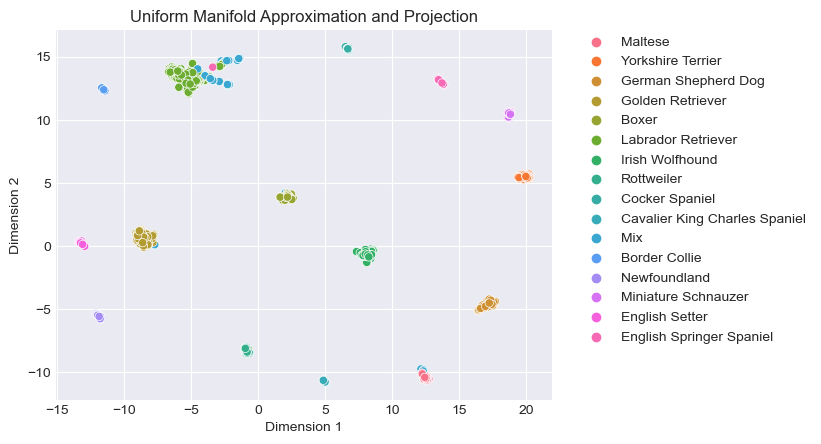

In [38]:
# Plot UMAP
sns.scatterplot(x = umap_X, 
                y = umap_Y, 
                hue = curr_color)
plt.title("Uniform Manifold Approximation and Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Deep Learning Methods

In [25]:
tensor_data    = torch.tensor(np.array(curr_data), dtype = torch.float32)

____
#### Autoencoders (AE)

In [26]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = True,
                            num_workers = 8)
ae             = autoencoder(num_channels = 1,
                             sample_size = tensor_data.shape[1],
                             categorical = False,
                             hyperparams = {'d' : 2, 'hidden_dims': [256, 128]})
trainer        = pl.Trainer(devices = 1,
                            max_epochs = 100,
                            accelerator = 'gpu')
trainer.fit(ae, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 21.1 M
1 | decoder     | Sequential | 33.4 K
2 | final_layer | Sequential | 21.2 M
-------------------------------------------
42.3 M    Trainable params
0         Non-trainable params
42.3 M    Total params
169.299   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [27]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = False,
                            num_workers = 8)
ae_embs        = ae.get_all_embeddings(dataloader)

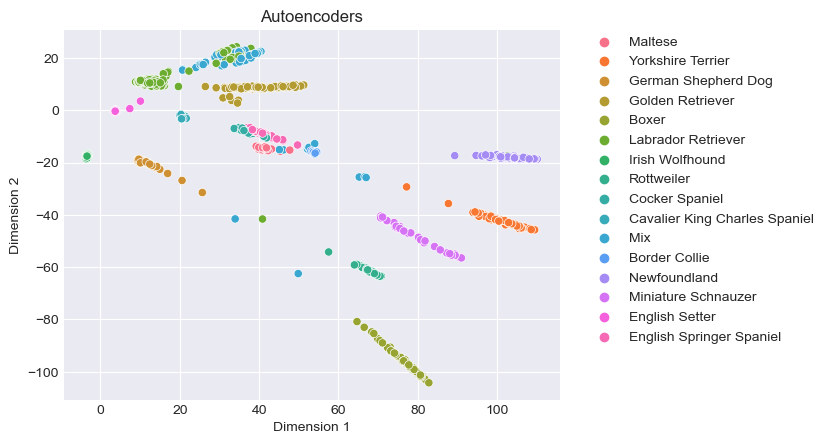

In [39]:
sns.scatterplot(x = ae_embs[:, 0], 
                y = ae_embs[:, 1], 
                hue = curr_color)
plt.title("Autoencoders")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

____
#### Variational Encoders (VAE)

In [29]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = True,
                            shuffle = True,
                            num_workers = 8)
vae            = VAE(num_channels = 1,
                     sample_size = tensor_data.shape[1],
                     categorical = False,
                     hyperparams = {'d': 2, 'kld_weight': 1., 'hidden_dims': [128, 64, 32, 16, 8, 4], 'kld_annealing': False})
trainer        = pl.Trainer(devices = 1,
                            max_epochs = 100,
                            accelerator = 'gpu')
trainer.fit(vae, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 10.6 M
1 | fc_mu       | Linear     | 10    
2 | fc_var      | Linear     | 10    
3 | decoder     | Sequential | 11.7 K
4 | final_layer | Sequential | 10.6 M
-------------------------------------------
21.2 M    Trainable params
0         Non-trainable params
21.2 M    Total params
84.774    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [30]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = False,
                            num_workers = 8)
vae_embs       = vae.get_all_embeddings(dataloader)

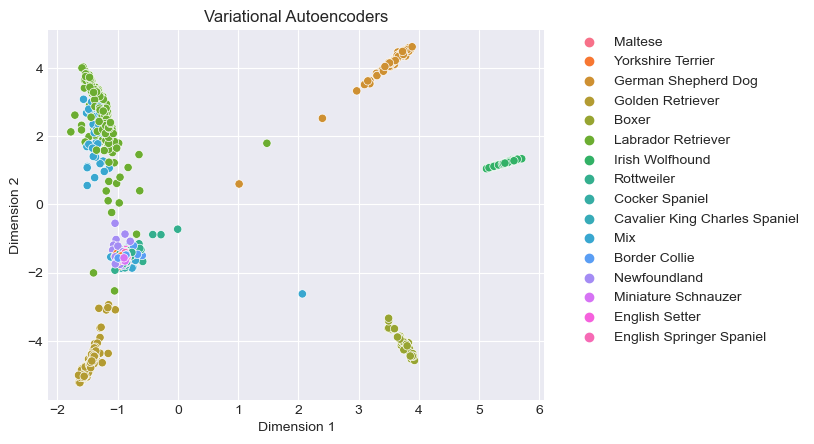

In [41]:
sns.scatterplot(x = vae_embs[:, 0], 
                y = vae_embs[:, 1], 
                hue = curr_color)
plt.title("Variational Autoencoders")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)